# MCMC Fitting the emission profile to an emission spectrum  

This example conducts HMC-NUTS fitting to a mock absorption line. We use Schwarzchild equation of the absorption model based on Tepper 
approximation of Voigt profile, lpf.FAbsVTc in exojax.lpf (line profile functions) module. 

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [1]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import lpf
from exojax.spec import rtransfer as rt

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/kawahara/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [3]:
# generating mock absorption data
np.random.seed(38)
N=1000
nur=1000
nuarr=jnp.linspace(-nur,nur,N)
sigin=0.01
sDfix = jnp.array(1.0)
gLfix = jnp.array(0.5)

Nmol=100
hatnufix = (np.random.rand(Nmol)-0.5)*nur*2
Sfix=np.random.rand(Nmol)
Afix=jnp.array(0.03)
nu0fix = 0.7
#f = lambda nu: lpf.MultiAbsVTc(nu-nu0fix,sDfix,gLfix,Afix,Sfix,hatnufix)

numatrix=lpf.make_numatrix(nuarr,hatnufix,nu0fix)
cs=rt.cross(numatrix,sDfix,gLfix,Afix,Sfix)


In [6]:
NP=17
Parr, k=rt.const_p_layer(NP=NP)
for i in range(0,NP-1):
    print(i, Parr[i]*k, Parr[i+1]-Parr[i],Parr[i])


0 0.007782794 0.0077827945 0.01
1 0.013839982 0.013839981 0.017782794
2 0.024611356 0.024611358 0.031622775
3 0.04376587 0.04376587 0.056234132
4 0.077827945 0.07782794 0.1
5 0.13839982 0.13839982 0.17782794
6 0.24611357 0.24611357 0.31622776
7 0.4376587 0.43765867 0.56234133
8 0.7782794 0.7782794 1.0
9 1.3839983 1.3839983 1.7782794
10 2.4611356 2.4611354 3.1622777
11 4.376587 4.376587 5.623413
12 7.782794 7.782795 10.0
13 13.839983 13.839981 17.782795
14 24.611357 24.611355 31.622776
15 43.765865 43.76587 56.23413


[autoreload of exojax.spec.rtransfer failed: Traceback (most recent call last):
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: const_p_layer() requires a code object with 1 free vars, not 0
]


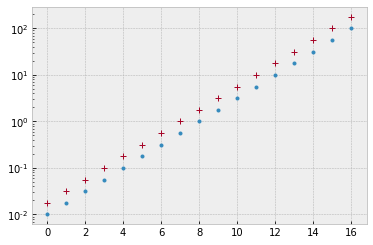

In [11]:
plt.plot(Parr,".")
plt.plot(Parr*(k+1),"+")
plt.yscale("log")

In [40]:
def add_layer(FP,x):
    """
    Params:
      FP: F[i], P[i]
      x: free parameters, T
      
    Returns:
      FP: F[i+1], P[i+1]
      dtaui: dtau of this layer
    """
    numic = 1.0
    F,Pi = FP
    Ti = x
    #dP = k*Pi
    gi = rt.nB(Ti,numic)
    dtaui =  1.e-2*k*Pi
    Trans=jnp.exp(-dtaui)
    F = F*Trans + gi
    FP=[F,Pi*(k+1)] #carryover 
    return FP,dtaui

In [41]:
Tarr = 500.*(Parr/Parr[0])**0.1
def g(xs):
    """
    Params: 
      xs: free parameters
    """
    Tarr=xs
    FP,null=scan(add_layer,[0.0,Parr[0]],Tarr,NP)
    return FP[0]

In [42]:

from jax import grad
scan(add_layer,[0.0,Parr[0]],Tarr,NP)

([DeviceArray(1.4293395e-05, dtype=float32),
  DeviceArray(177.82797, dtype=float32)],
 DeviceArray([7.7827935e-05, 1.3839983e-04, 2.4611357e-04, 4.3765869e-04,
              7.7827950e-04, 1.3839983e-03, 2.4611359e-03, 4.3765875e-03,
              7.7827950e-03, 1.3839984e-02, 2.4611359e-02, 4.3765873e-02,
              7.7827953e-02, 1.3839984e-01, 2.4611360e-01, 4.3765876e-01,
              7.7827954e-01], dtype=float32))

In [43]:
g(Tarr)

DeviceArray(1.4293395e-05, dtype=float32)

In [44]:
from jax import jit
h=jit(grad(g))

In [45]:
h(Tarr)

DeviceArray([3.09582495e-15, 1.38009865e-14, 5.62323964e-14,
             2.10488067e-13, 7.27383485e-13, 2.33162946e-12,
             6.96562729e-12, 1.94880136e-11, 5.13297391e-11,
             1.28075661e-10, 3.05187903e-10, 7.02575553e-10,
             1.59082136e-09, 3.64834407e-09, 8.90737972e-09,
             2.52400412e-08, 9.65816582e-08], dtype=float32)

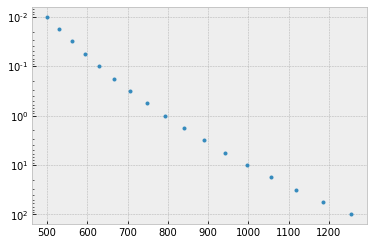

In [101]:
Tarr = 500.*(Parr/Parr[0])**0.1

plt.plot(Tarr,Parr,".")
#plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()

In [6]:
dtau=rt.calc_dtau(dP,cs,1,1,1)
tau=rt.calc_tau(dtau)

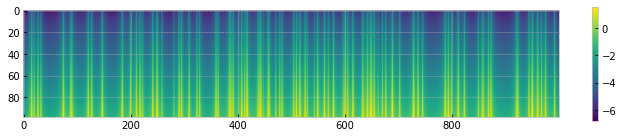

In [7]:
fig=plt.figure(figsize=(12,3))
ax=fig.add_subplot(111)
a=ax.imshow(jnp.log10(tau))
plt.colorbar(a,shrink=0.7)
ax.set_aspect(0.2/ax.get_data_ratio())
plt.show()

In [11]:
def fdeltaI(carry,x):
    dtau,T=x
    source_function = Bplanck(T)
    y=beta_OK(dtau)*source_function + gamma_OK(dtau)*carry
    carry=source_function
    return carry, y

def alpha_OK(dtau):
    (jnp.exp(-dtau) - 1)/dtau 

def beta_OK(dtau):
    return 1 + alpha_OK(dtau)

def gamma_OK(dtau):
    return - jnp.exp(-dtau) - alpha_OK(dtau)

In [12]:
dI=scan(fdeltaI,0,jnp.array([dtau,Tarr]))

NameError: name 'scan' is not defined